In [21]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import keras
from keras import layers
import pandas as pd
from tensorflow.keras.optimizers import Adam

# 2. Primer goste nevronske mreže za napoved kategorij – binarni primer

V naslednjem primeru bomo pokazali, kako lahko model iz zveznih neodvisnih podatkov napove diskreten podatek (kategorijo). To je pogosta uporaba nevronskih mrež – iz množice lastnosti želimo identificirati objekt ali razporediti podatke v kategorije. Uporabo nevronske mreže za klasifikacijo bomo prikazali na preprostem primeru dveh kategorij.

Sivi lasje so običajno debelejši od obarvanih. Zato bomo izdelali nevronsko mrežo, ki bo iz debeline lasu poskušala ugotoviti, ali je las obarvan ali siv. Predpostavili bomo, da sta debelini sivih in obarvanih las razporejeni po normalni porazdelitvi z enako standardno deviacijo, a z različnim povprečjem. Uspešnost učenja modela bo seveda odvisna od tega, kako sta kategoriji ločeni – bolj kot se Gaussovi porazdelitvi prekrivata, težje bo modelu natančno napovedati, za kakšen las gre.

## 2.1 Generiranje podatkov

Zgenerirali bomo N debelin las – N/2 za sive in N/2 za obarvane lase. Model se najbolje uči na podatkih, kjer so vse kategorije enakomerno zastopane. Ker imamo le dve kategoriji, lahko za označevanje kategorij uporabimo preprosta števila 0 in 1, kjer 0 pomeni sivi las, 1 pa obarvani.

Najprej bomo zgenerirali debeline in jih grafično prikazali.

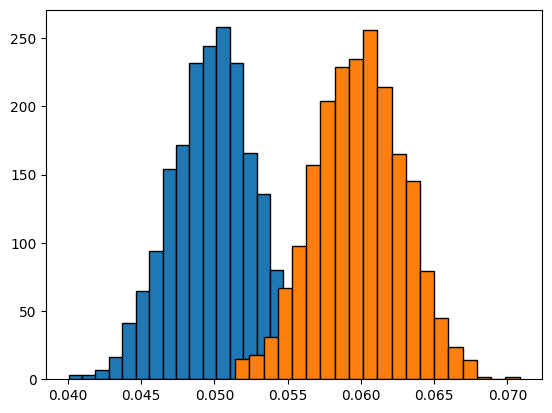

In [2]:
#generiramo n podatkov za sive in n za barvne lase - skupaj torej 2n podatkov. Definiramo povprečno debelino 
# in povprečno standardno deviacijo. Ta naj bo enaka za oba tipa las, ker ne izgubljamo na splošnosti
n = 2000
povp_obarvani = 0.06 #milimetrov
povp_sivi = 0.05 #milimetrov
std = 0.003 #milimetrov

# nastavimo, da vedno generira iste podatke - zaradi lažje kontrole
np.random.seed(10)

#Zgeneriramo debeline
sivi_deb=np.random.normal(loc=povp_sivi, scale=std, size=n)
obarvani_deb=np.random.normal(loc=povp_obarvani, scale=std, size=n)
plt.hist(sivi_deb, bins=20, edgecolor='black')
plt.hist(obarvani_deb,bins=20, edgecolor='black')
plt.show()



Podatke nato uredimo v obliko, ki jo model razume. Najprej generiramo arraya z oznakami kategorij (torej en array samo z ničlami in en array samo z enicami). Arraye nato združimo tako, da prvi stolpec predstavlja debelino las, drugi pa oznako barve.

In [3]:
sivi_ozn=np.zeros(n) #generiramo array velikosti n s samimi ničlami
obarvani_ozn=np.ones(n) #generiramo array velikost n s samimi enkami

#Podatke uredimo v stolpce in vrstice, tako da bo debelina prvem stolpcu in oznaka barve las v drugem stolpcu
sivi=np.vstack([sivi_deb,sivi_ozn])
obarvani=np.vstack([obarvani_deb,obarvani_ozn])
sivi=sivi.T
obarvani=obarvani.T
# izpišemo prvih pet členov obeh seznamov
print(sivi[:5]) 
print()
print(obarvani[:5])



[[0.05399476 0.        ]
 [0.05214584 0.        ]
 [0.0453638  0.        ]
 [0.04997485 0.        ]
 [0.05186401 0.        ]]

[[0.05611527 1.        ]
 [0.06202781 1.        ]
 [0.0598085  1.        ]
 [0.05858464 1.        ]
 [0.05874152 1.        ]]


Dobljena seznama združimo z ukazom concatenate (namesto vstack), s čimer odstranimo mejo med seznamoma, nato pa podatke premešamo.

In [4]:
# podatke združimo v eno tabeo, jih premežamo in izpišemo prvih pet členov
podatki=c = np.concatenate((sivi, obarvani))
np.random.shuffle(podatki)
print(podatki[:5])

[[0.05176412 0.        ]
 [0.04848002 0.        ]
 [0.04674326 0.        ]
 [0.05089108 0.        ]
 [0.06357407 1.        ]]


Podatke razdelimo na vhodne (X) in izhode (Y). Razdelitev na podatke za treniranje in validacijo bo izvedena med samo fazo učenja z uporabo parametra **validation_split**.

In [5]:
podatki=podatki.T
X=podatki[0]
Y=podatki[1]

## 2.2 Postavitev modela

Postavljanje modela poteka podobno kot pri napovedi zveznih vrednosti, z nekaj pomembnimi razlikami:

Pri izdelavi arhitekture moramo paziti, kako oblikovati izhodno plast. Želimo, da nam model kot napoved vrne število med 0 in 1, ki nam pove, kako verjetno je, da je las siv oziroma obarvan. Vrednost 0 pomeni, da je las 100 % siv, vrednost 0.3 pa, da je las s 30 % verjetnostjo obarvan in 70 % verjetnostjo siv. Zato moramo:

 1. dimenzijo izhodne plasti nastaviti na 1,

 2. na izhodni plasti uporabiti aktivacijsko funkcijo sigmoid, ki poskrbi, da bodo izhodne vrednosti preslikane na interval 0–1.

Pri pripravi modela:

 3. za stroškovno funkcijo uporabimo binary_crossentropy (ali sparse_categorical_crossentropy), ki je oblikovana posebej za izhode oblike 0 ali 1,

 4. za metriko uporabimo accuracy, saj jo je najlažje interpretirati – pove, v kolikšnem deležu smo pravilno uganili kategorijo. Na primer, accuracy = 0.95 pomeni, da smo od 100 primerov pravilno napovedali 95-krat in se zmotili 5-krat.

In [6]:
# ------ Postavitev arhitekture -----
model = keras.Sequential([
    layers.Dense(16, activation="relu", input_shape=(1,)),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # binarni izhod
])
model.summary()

# ------ Priprava modela ------
model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss="binary_crossentropy",
    metrics=["accuracy"])
    


# ---- Treniranje ----
ucenje = model.fit(
    X, Y,
    validation_split=0.2,
    epochs=20,
    batch_size=30,
    verbose=0)

/home/anita/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-13 16:56:54.691477: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177 (708.00 B)

 Trainable params: 177 (708.00 B)

 Non-trainable params: 0 (0.00 B)

Narišemo še grafa stroškovne funkcije in metrike (natančnost):

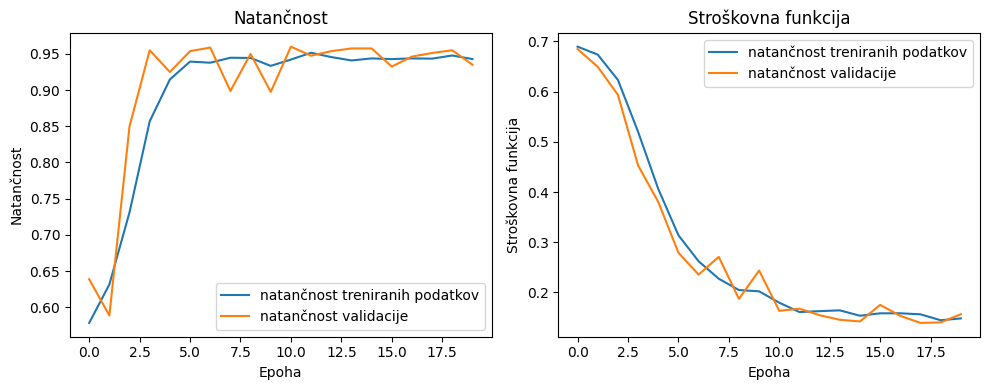

In [7]:
# ---- Graf metrike in stroškovne funkcije ----
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ucenje.history["accuracy"], label="natančnost treniranih podatkov")
plt.plot(ucenje.history["val_accuracy"], label="natančnost validacije")
plt.xlabel("Epoha"); plt.ylabel("Natančnost"); plt.legend(); plt.title("Natančnost")

plt.subplot(1,2,2)
plt.plot(ucenje.history["loss"], label="natančnost treniranih podatkov")
plt.plot(ucenje.history["val_loss"], label="natančnost validacije")
plt.xlabel("Epoha"); plt.ylabel("Stroškovna funkcija"); plt.legend(); plt.title("Stroškovna funkcija")

plt.tight_layout()


Zdaj bomo model tudi uporabili. Najprej zgenerirajmo 100 novih podatkov in preverimo, kako dobro model deluje. Model nam kot rezultat vrne število med 0 in 1. Če je število blizu 0, to pomeni, da je las verjetno siv, če pa je blizu 1, je las verjetno obarvan. Z drugimi besedami, vrednost, ki jo model prikaže, nam pove verjetnost, da je las obarvan.

In [8]:
# ---- generiranje novih 100 podatkov ------
n1=100
sivi_deb_novi=np.random.normal(loc=povp_sivi, scale=std, size=n1)
obarvani_deb_novi=np.random.normal(loc=povp_obarvani, scale=std, size=n1)
sivi_ozn_novi=np.zeros(n1) #generiramo array velikosti n s samimi ničlami
obarvani_ozn_novi=np.ones(n1) #generiramo array velikost n s samimi enkami

#Podatke uredimo v stolpce in vrstice, tako da bo debelina prvem stolpcu in oznaka barve las v drugem
sivi_novi=np.vstack([sivi_deb_novi,sivi_ozn_novi])
obarvani_novi=np.vstack([obarvani_deb_novi,obarvani_ozn_novi])
sivi_novi=sivi_novi.T
obarvani_novi=obarvani_novi.T

test = np.concatenate((sivi_novi, obarvani_novi))
np.random.shuffle(test)
test=test.T
X_novi=test[0].reshape(-1,1)
Y_novi=test[1].reshape(-1,1)

# ------ uporaba modela - napoved vrste las ------
Y_pred = model.predict(X_novi, verbose=0)
#y_pred = (y_pred_prob >= 0.5).astype(int)
print(np.round(Y_pred[0:10], 2))
Y_pred=np.round(Y_pred, 0)


[[0.03]
 [0.99]
 [0.69]
 [0.95]
 [0.4 ]
 [0.98]
 [1.  ]
 [0.03]
 [0.03]
 [0.92]]


Prikažimo še rezultate s pomočjo **matrike zmede**. Matrika zmede nam bolj pregledno prikaže, kako dobro deluje naš model, saj pokaže: koliko krat smo obarvan las pravilno prepoznali kot obarvanega, koliko krat smo obarvan las zmotno označili za siv, koliko krat smo sivi las zmotno označili za obarvanega in koliko krat smo sivi las pravilno prepoznali kot siv.

Za prikaz matrike zmede lahko uporabimo ukaz **confusion_matrix** iz knjižnice **sklearn.metrics**.

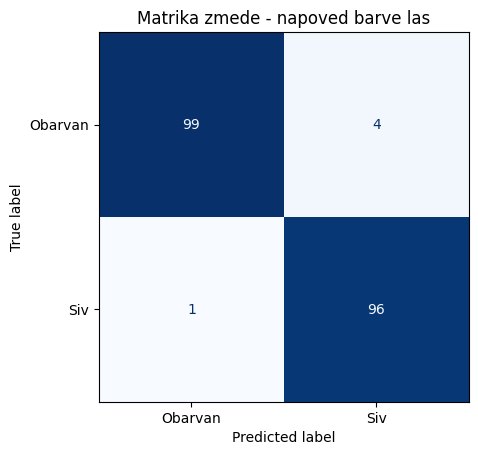

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# ---- Matrika zmede ----
cm = confusion_matrix(Y_pred, Y_novi)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Obarvan", "Siv"])
disp.plot(cmap="Blues", colorbar=False)
plt.title("Matrika zmede - napoved barve las")
plt.show()



# 3. Primer goste nevronske mreže za napoved kategorij – več kategorij

Poglejmo sedaj, kako enako nalogo rešiti v primeru, ko imamo več kategorij.

Prebivalci (Evropejci, Afričani in Azijci) se med seboj razlikujejo tudi po povprečni debelini las. Povprečna debelina afriških las je 0,055 mm, evropskih 0,065 mm, azijskih pa 0,080 mm. Enako kot v prejšnjem primeru bomo torej generirali 3 × n debelin las za n prebivalcev vsakega kontinenta.

## 3.1 Generiranje podatkov

Najprej zgenerirajmo podatke. Ker so podatki pogosto podani v obliki tabele, bomo tokrat naredili nekoliko drugače – zgenerirane podatke bomo najprej zapisali v **pandas DataFrame**, nato pa jih iz **DataFrame** oblike  prebrali v obliko, ki jo razume **UI model**.


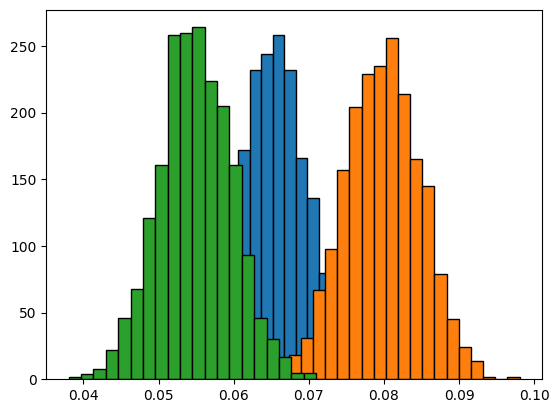

,debeline,poreklo
0,0.071658,evropa
1,0.068576,evropa
2,0.057273,evropa
3,0.064958,evropa
4,0.068107,evropa


In [12]:
# --- definicija parametrov ---
n = 2000
povp_evropa = 0.065 #milimetrov
povp_azija = 0.08 #milimetrov
povp_afrika=0.055
std = 0.005 #milimetrov

# nastavimo, da vedno generira iste podatke - zaradi lažje kontrole
np.random.seed(10)

# ---    Zgeneriramo debeline
evropa_deb=np.random.normal(loc=povp_evropa, scale=std, size=n)
azija_deb=np.random.normal(loc=povp_azija, scale=std, size=n)
afrika_deb=np.random.normal(loc=povp_afrika, scale=std, size=n)

#  ---- Gafični prikaz
plt.hist(evropa_deb, bins=20, edgecolor='black')
plt.hist(azija_deb,bins=20, edgecolor='black')
plt.hist(afrika_deb,bins=20, edgecolor='black')
plt.show()

# ---- Zgenerirajmo poreklo 
evropa_ozn=(["evropa"] * n)
azija_ozn=(["azija"] * n)
afrika_ozn=(["afrika"] * n)

# --- združimo sezname in jih zapišemo v pandas DataFrame
debeline=np.concatenate([evropa_deb,azija_deb,afrika_deb])
poreklo=np.concatenate([evropa_ozn,azija_ozn,afrika_ozn])
df = pd.DataFrame({"debeline":debeline, "poreklo":poreklo})
df.head()

Na koncu tabelo še premešamo. Uporabimo lahko ukaz sample, ki naključno izbere vrstice. Parameter frac=1 pomeni, da vzamemo vse vrstice. Funkcija reset_index(drop=True) pa poskrbi, da se vrstice ponovno oštevilčijo od začetka.

In [13]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,debeline,poreklo
0,0.060351,evropa
1,0.085726,azija
2,0.044821,afrika
3,0.061035,afrika
4,0.051660,afrika


Ko imamo pripravljeno tabelico, je potrebno podatke iz** nje pripraviti v obliki, ki jo Keras razume. Imamo dve možnosti označevanja kategorij: kot **one-hot vektorje** ([1,0,0], [0,1,0], [0,0,1]) ali kot **številčne kategorije** (0, 1, 2).

## 3.2 Model s številčnimi kategorijami

Poglejmo, kako uporabiti številčne kategorije. Najprej bomo s pomočjo ukaza **LabelEncoder** dodali novo vrstico, kjer naše opisne kategorije pretvorimo v številke 0, 1 in 2.

In [15]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# dodamo še eno vrstico v tabeli, da poreklo spremenimo v oznake 0, 1 in 2
encoder = LabelEncoder()
df["oznaka"] = encoder.fit_transform(df["poreklo"])

#Podatke "poberemo" v arraye
X = df["debeline"].values   
Y = df["oznaka"].values    

df.head()

,debeline,poreklo,oznaka
0,0.060351,evropa,2
1,0.085726,azija,1
2,0.044821,afrika,0
3,0.061035,afrika,0
4,0.051660,afrika,0


Pri pripravi modela je potrebno paziti na naslednje:

 - Zadnja plast (output layer) naj ima aktivacijsko funkcijo softmax.

 - Zadnja plast naj ima tri izhode (za tri kategorije).

 - Za stroškovno funkcijo (loss) uporabimo sparse_categorical_crossentropy.

Epoch 1/10


/home/anita/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3531 - loss: 1.0951 - val_accuracy: 0.6417 - val_loss: 1.0658
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5433 - loss: 1.0295 - val_accuracy: 0.7092 - val_loss: 0.8318
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7147 - loss: 0.7496 - val_accuracy: 0.8550 - val_loss: 0.5621
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8280 - loss: 0.5472 - val_accuracy: 0.8450 - val_loss: 0.4664
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8454 - loss: 0.4509 - val_accuracy: 0.8617 - val_loss: 0.3927
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8453 - loss: 0.4111 - val_accuracy: 0.8700 - val_loss: 0.3648
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8479 - loss: 0.3908 - val_accuracy: 0.8692 - val_loss: 0.3489
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8409 - loss: 0.3832 - val_accuracy: 0.8650 - val_

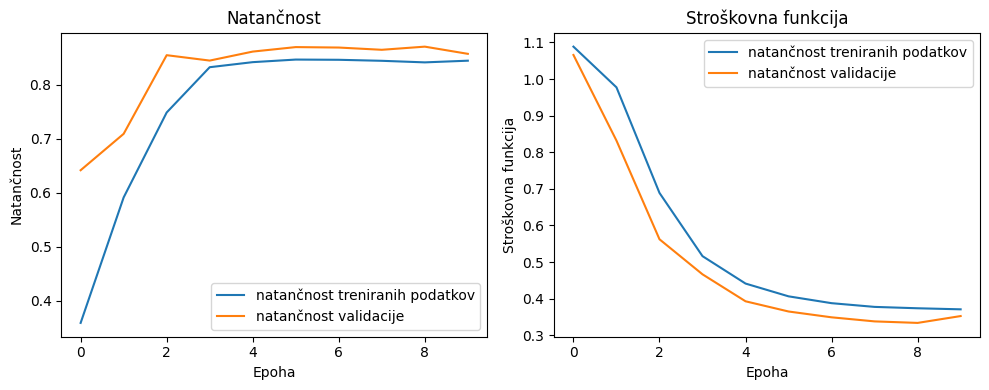

In [16]:
# --- Definicija modela ---
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(1,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

# --- Priprava modela ---
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- Učenje modela  ---
ucenje = model.fit(X, Y, epochs=10, batch_size=8, validation_split=0.2)

# ---- Graf metrik ----
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ucenje.history["accuracy"], label="natančnost treniranih podatkov")
plt.plot(ucenje.history["val_accuracy"], label="natančnost validacije")
plt.xlabel("Epoha"); plt.ylabel("Natančnost"); plt.legend(); plt.title("Natančnost")

plt.subplot(1,2,2)
plt.plot(ucenje.history["loss"], label="natančnost treniranih podatkov")
plt.plot(ucenje.history["val_loss"], label="natančnost validacije")
plt.xlabel("Epoha"); plt.ylabel("Stroškovna funkcija"); plt.legend(); plt.title("Stroškovna funkcija")

plt.tight_layout()





Poglejmo še, kakšne oblike je izhod.

In [17]:

X_novi=np.random.normal(loc=0.07, scale=0.01, size=10)
Y_pred = model.predict(X_novi, verbose=0)
print(np.round(Y_pred,2))

[[0.1  0.06 0.84]
 [0.03 0.18 0.79]
 [0.   0.83 0.17]
 [0.   0.91 0.09]
 [0.   0.98 0.02]
 [0.   0.61 0.39]
 [0.52 0.   0.48]
 [0.   0.86 0.14]
 [0.13 0.04 0.83]
 [0.75 0.   0.25]]


## 3.3 Model z one hot vektorji

Podobno stvar lahko izvedemo z one-hot notacijo. Začnemo na enak način - najprej dodamo vrstico s številčno notacijo s pomočjo funkcije encode, nato pa z ukazom to_categorical spremenimo zapis v one-hot vektor. Ker smo številčno notacijo že dodali, nadaljujemo s pretvorbo podatkov v one-hot vektorsko obliko.

In [19]:
y_num = encoder.transform(df["poreklo"])
Y_cat = to_categorical(y_num)
print(Y_cat)

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


Model oblikujemo na enak način z eno pomembno razliko - kot stroškovno funkcijo sedaj moramo uporabiti **'categorical_crossentropy'**.

Epoch 1/10


/home/anita/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3390 - loss: 1.0965 - val_accuracy: 0.7833 - val_loss: 1.0570
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6519 - loss: 0.9958 - val_accuracy: 0.7992 - val_loss: 0.7388
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7920 - loss: 0.6845 - val_accuracy: 0.8600 - val_loss: 0.5307
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8317 - loss: 0.5165 - val_accuracy: 0.8017 - val_loss: 0.4984
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8374 - loss: 0.4581 - val_accuracy: 0.8642 - val_loss: 0.4019
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8368 - loss: 0.4215 - val_accuracy: 0.8667 - val_loss: 0.3697
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8463 - loss: 0.3819 - val_accuracy: 0.8633 - val_loss: 0.3533
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8432 - loss: 0.3698 - val_accuracy: 0.8325 - val_

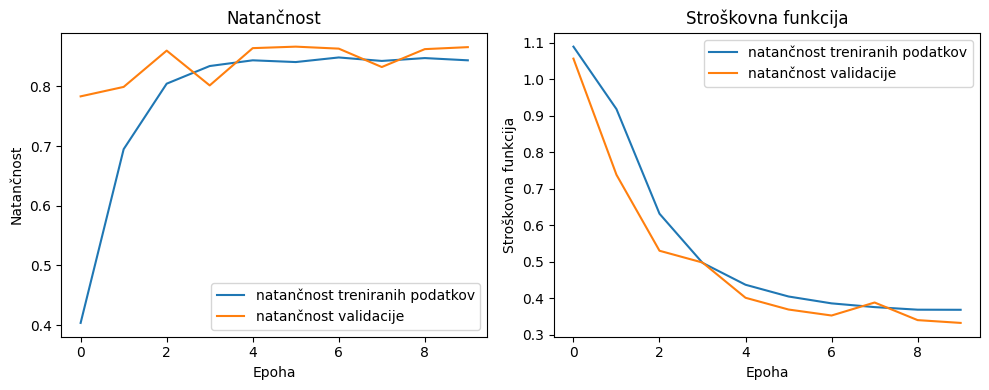

In [20]:
# --- Definicija modela ---
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(1,)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

# --- Compile ---
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- Train (z validation split) ---
ucenje = model.fit(X, Y_cat, epochs=10, batch_size=8, validation_split=0.2)

# ---- Graf metrik ----
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ucenje.history["accuracy"], label="natančnost treniranih podatkov")
plt.plot(ucenje.history["val_accuracy"], label="natančnost validacije")
plt.xlabel("Epoha"); plt.ylabel("Natančnost"); plt.legend(); plt.title("Natančnost")

plt.subplot(1,2,2)
plt.plot(ucenje.history["loss"], label="natančnost treniranih podatkov")
plt.plot(ucenje.history["val_loss"], label="natančnost validacije")
plt.xlabel("Epoha"); plt.ylabel("Stroškovna funkcija"); plt.legend(); plt.title("Stroškovna funkcija")

plt.tight_layout()